<a href="https://colab.research.google.com/github/sametgirgin/Python-Projects/blob/main/HRES_Optimizasyonu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hibrit Yenilenebilir Enerji Sisteminin Optimizasyonu

Proje, güneş panelleri, rüzgar türbinleri ve batarya depolamayı içeren hibrti bir sistemin optimizasyonunu inceliyor. Sistem, çeşitli yenilenebilir kaynakları entegre ederek güvenilir, sürdürülebilir bir güç kaynağı sağlamayı amaçlamaktadır.

**Sistemin Tanımı**:

PV Paneli: 100 kW toplam kapasite ve PV verimim %20

Wind Turbines: 3*50 kW = 150 kW kapasite ve verim %30

Batarya: 200 kWh kapasite

**Maliyetler**:

Güneş maliyeti: $0.12/kwh

Rüzgar Maliyeti: $0.15/kwh

Batarya Maliyet: $0.05 /kwh


**Amaç**

Çalışma, hibit enerji sisteminin enerji dönüşüm süreçlerini simüle etmek için bir matematiksel modelin geliştirilmesine odaklanmaktadır. Model, Python'un ve numpy ve scipy gibi kütüphaneleri kullanarak, sistemin verimlilik parametrelerine dayalı olarak güç çıkışını hesaplamak için kritik olan güneş panelleri için ışınım miktarını ve türbinler için rüzgar hızını hesaba katar.


**Veri Seti**

Verisetine aşıdaki adresten erişilebilir.

https://github.com/sametgirgin/Hibrit-Enerji-Sistemi

In [ ]:
# prompt: import pandas,numpy,scipy, matplot libraries
from google.colab import output
output.enable_custom_widget_manager()

!pip install scipy
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import scipy.optimize as minimize
import matplotlib.pyplot as plt

In [ ]:
weather_data = '/content/drive/MyDrive/ColabNotebooks/weather_data.csv'
demand_data = '/content/drive/MyDrive/ColabNotebooks/demand_data.csv'

hava_verileri = pd.read_csv(weather_data)
talep_verileri = pd.read_csv(demand_data)

In [ ]:
hava_verileri.head()

,date,solar_irradiance,wind_speed
0,2023-01-01,540.501829,17.619719
1,2023-01-02,525.345852,20.905963
2,2023-01-03,710.161241,9.970755
3,2023-01-04,335.602992,9.863876
4,2023-01-05,422.918784,16.225939


In [ ]:
talep_verileri.head()

,date,energy_demand
0,2023-01-01,9446.086541
1,2023-01-02,9597.879884
2,2023-01-03,6601.962339
3,2023-01-04,7197.282079
4,2023-01-05,5645.435393


Sistem Parametreleri ve Modelleri Belirle

In [ ]:
#Sabit değerler (Maliyet $/kWh)
cost_solar = 0.12
cost_wind = 0.15
cost_storage  = 0.05

# (Kapasite kW vs kWh)
max_pv_capacity = 100
max_wind_capacity = 150
battery_capacity = 200

# Solar üretim modeli
def solar_production(irradiance, verim):
    solar_output = irradiance * max_pv_capacity * verim
    return solar_output
# Rüzgar Üretim Modeli
def wind_production(wind_speed, verim):
    wind_output = wind_speed * max_wind_capacity * verim
    adjusted_wind_output = np.where(wind_speed <10, wind_output*0.5, wind_output)
    return adjusted_wind_output

Optimizasyon için Amaç Fonksiyonu Hazırlanır

In [ ]:
Talep = talep_verileri["energy_demand"].values

def total_cost(x):
  solar_enerji = solar_production(hava_verileri["solar_irradiance"].values, x[0])
  rüzgar_enerji = wind_production(hava_verileri["wind_speed"].values, x[1])
  depolama = x[2] * battery_capacity
  energy_def = Talep - (solar_enerji + rüzgar_enerji + depolama)

  toplam_enerji = solar_enerji + rüzgar_enerji + depolama
  toplam_maliyet = (solar_enerji * cost_solar + rüzgar_enerji * cost_wind + depolama * cost_storage + energy_def * 0.15).sum()
  return toplam_maliyet

print(Talep)

[9446.0865411  9597.87988396 6601.96233923 7197.28207884 5645.43539338
 9012.73947981 9798.90112487 8151.55865049 8206.30597054 9466.95828276
 7409.63970967 7219.99217659 6554.70062893 6242.60932751 5029.98243339
 7757.07373776 7975.16823577 8099.01510445 7858.00930885 8047.16091523
 5492.01400857 5881.48944466 5688.06774875 9854.23782032 6503.02051105
 6816.58635227 6735.55370312 5522.87762327 9720.10768749 9638.69167807
 5268.19923391]


Sistem Konfigürasyonunu Optimize Etmek:

**İlk Tahmin (x0)**: Bu dizi optimizasyon değişkenleri için ilk tahminleri temsil eder. Bu bağlamda x0[0] güneş paneli verimliliği için ilk tahmin, x0[1] ise rüzgar türbini verimliliği için ilk tahmindir.
ve x0[2] kullanılan depolama kapasitesinin oranı içindir. Bun tahminler optimizasyon algoritmasının başlangıç ​​noktalarıdır

**Sınırlar**: Optimizasyon değişkenleri için Min-max değerleri
güneş panel verimliliği için aralık 0.1-0.3 arası, rüzgar türbin verimi aralığı 0.2-0.4 arası, depolama oranı 0-1 arası

**Minimize fonksiyonu** (from scipy.optimize) toplam maliyet fonksiyonunun minimum yapan değişken kümelerini bulur. (The TNC (Truncated Newton Algorithm) method is specified for the optimization process,
suitable for this type of constrained optimization problem)


In [ ]:
x0 = [0.2, 0.3, 0.5]
sınırlar = [(0.1, 0.3), (0.2, 0.4), (0, 1)]
sonuc = minimize.minimize(total_cost, x0, bounds=sınırlar, method="TNC")

Yenilenebilir Enerji Üretim ve Depolamayı Optimize Etme

In [ ]:
#Optimize edilen güneş enerjisi hesabı
optimized_solar_energy = solar_production(hava_verileri["solar_irradiance"], sonuc.x[0])
#Optimize edilen rüzgar enerjisi hesabı
optimized_wind_energy = wind_production(hava_verileri["wind_speed"], sonuc.x[1])
#Optimize edilen depolama enerjisi hesabı
optimized_battery_usage = sonuc.x[2] * battery_capacity

In [ ]:
print("Optimizasyon Sonucu:", sonuc.x)

Optimizasyon Sonucu: [0.3        0.29999999 1.        ]


Sonuçları Görselleştirme

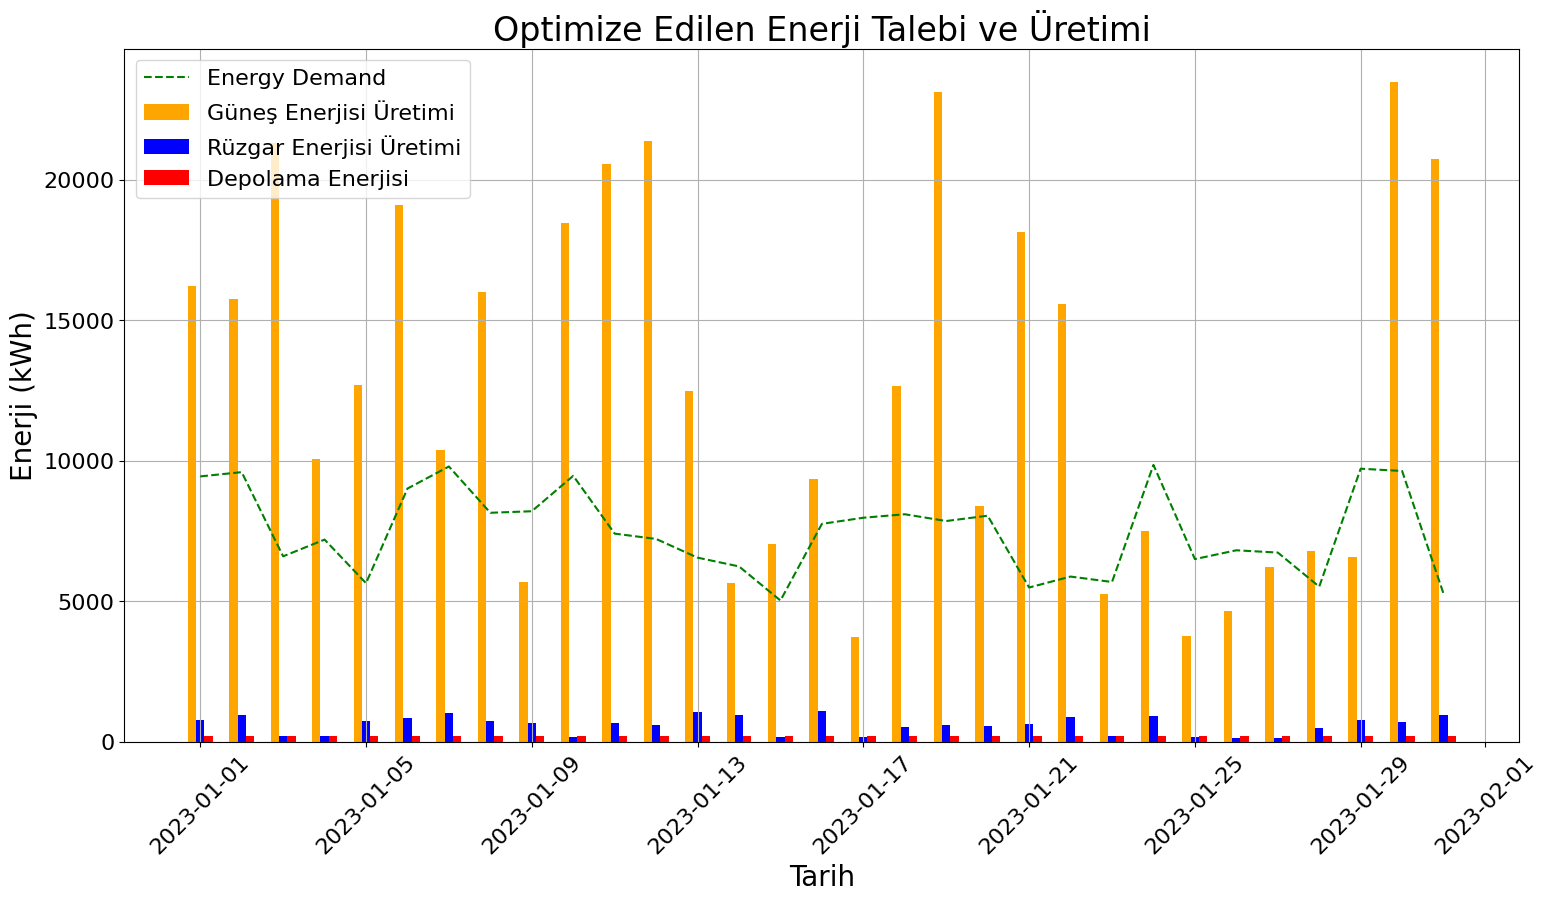

In [ ]:
#Ocak 2023 için tarih üretimi
dates=pd.date_range(start="2023-01-01",end="2023-01-31", freq="D")
fig, ax = plt.subplots(figsize=(18, 9))
width = 0.2

ax.bar(dates-pd.Timedelta(days=width),optimized_solar_energy,width, label = "Güneş Enerjisi Üretimi", color ="orange")
ax.bar(dates,optimized_wind_energy,width, label = "Rüzgar Enerjisi Üretimi", color ="blue")
ax.bar(dates+pd.Timedelta(days=width),optimized_battery_usage,width, label = "Depolama Enerjisi", color ="red")

#Enerji talebi karşılaştırmak için çizilir
ax.plot(dates, Talep, "g--", label ="Energy Demand")

#Başlık ve etiket işaretleme
ax.set_title("Optimize Edilen Enerji Talebi ve Üretimi", fontsize = 24)
ax.set_xlabel("Tarih", fontsize =20)
ax.set_ylabel("Enerji (kWh)", fontsize=20)

ax.tick_params(axis="x", rotation=45, labelsize=16)
ax.tick_params(axis="y", labelsize=16)

ax.legend(fontsize=16)
ax.grid(True)